# Electricity Price Forecasting

## Goals

1.  Explore seasonality and trends in electricity prices
2.  Build models to forecast electricity prices
3.  Bring in external data to complement historical price data

In [167]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


In [168]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [272]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error
from meteostat import Monthly, Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [170]:
path = '/kaggle/input/electricity-prices/clean_data.csv'
df = pd.read_csv(path)
df.head()

,year,month,stateDescription,sectorName,customers,price,revenue,sales
0,2001,1,Wyoming,all sectors,NaN,4.31,48.12840,1116.17208
1,2001,1,Wyoming,commercial,NaN,5.13,12.67978,247.08691
2,2001,1,Wyoming,industrial,NaN,3.26,19.60858,602.30484
3,2001,1,Wyoming,other,NaN,4.75,0.76868,16.17442
4,2001,1,Wyoming,residential,NaN,6.01,15.07136,250.60591


## Exploratory Data Analysis

* Univariate Analysis
* Covariate analyis
* Time series visualization
* Time series decomposition

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85870 entries, 0 to 85869
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              85870 non-null  int64  
 1   month             85870 non-null  int64  
 2   stateDescription  85870 non-null  object 
 3   sectorName        85870 non-null  object 
 4   customers         59830 non-null  float64
 5   price             85870 non-null  float64
 6   revenue           85870 non-null  float64
 7   sales             85870 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 5.2+ MB


In [172]:
df.describe()

,year,month,customers,price,revenue,sales
count,85870.000000,85870.000000,5.983000e+04,85870.000000,85870.000000,85870.000000
mean,2012.043321,6.480144,2.916013e+06,9.300193,586.627155,5980.048970
std,6.660304,3.461589,1.200567e+07,5.010382,2161.047702,21302.453181
min,2001.000000,1.000000,0.000000e+00,0.000000,-0.000010,0.000000
25%,2006.000000,3.000000,4.998000e+03,6.650000,29.475195,289.144572
50%,2012.000000,6.000000,2.997540e+05,8.840000,121.641500,1447.518085
75%,2018.000000,9.000000,2.028716e+06,11.380000,421.320628,4339.950965
max,2024.000000,12.000000,1.625050e+08,116.670000,52361.450970,391900.008970


### To do
* Check if there is data from each month from January 2001 to 2024
* Visualize

### Univariate Analysis

In [173]:
df['sectorName'].value_counts()

sectorName
all sectors       17174
commercial        17174
industrial        17174
residential       17174
transportation    15686
other              1488
Name: count, dtype: int64

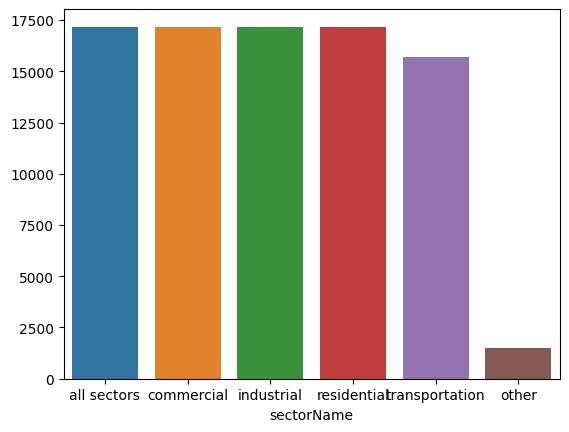

In [174]:
sns.barplot(x = df['sectorName'].value_counts().index, y = df['sectorName'].value_counts().values)
plt.show()

In [175]:
df['stateDescription'].value_counts()

stateDescription
Wyoming          1385
Kansas           1385
North Dakota     1385
Ohio             1385
Oklahoma         1385
                 ... 
Montana          1385
Nebraska         1385
Nevada           1385
New Hampshire    1385
Pennsylvania     1385
Name: count, Length: 62, dtype: int64

In [176]:
df['stateDescription'].unique()

array(['Wyoming', 'New England', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Alabama', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Middle Atlantic', 'Pacific Contiguous',
       'Pacific Noncontiguous', 'U.S. Total', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Rhode Island', 'Alaska', 'Arizona', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'East North Central',
       'West North Central', 'South Atlantic', 'East South Central',
       'West South Central', 'Mountain', 'Pennsylvania'], dtype=object)

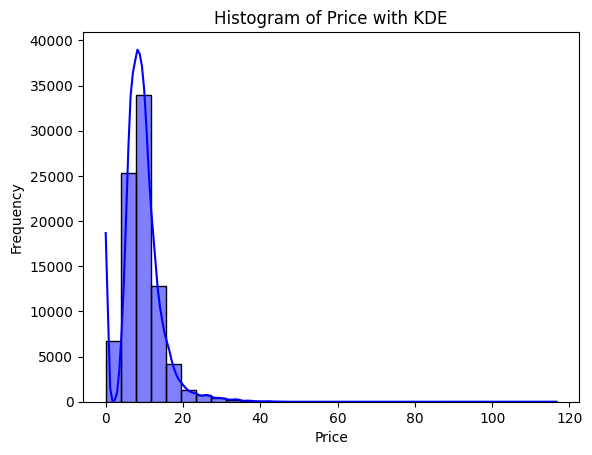

In [177]:
sns.histplot(df['price'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histogram of Price with KDE")

# Show the plot
plt.show()

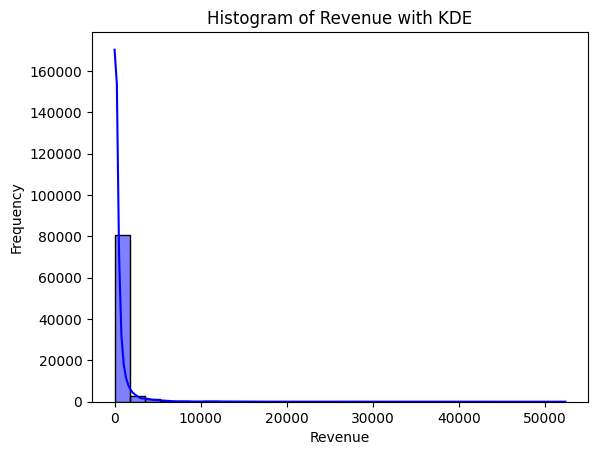

In [178]:
sns.histplot(df['revenue'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.title("Histogram of Revenue with KDE")

# Show the plot
plt.show()

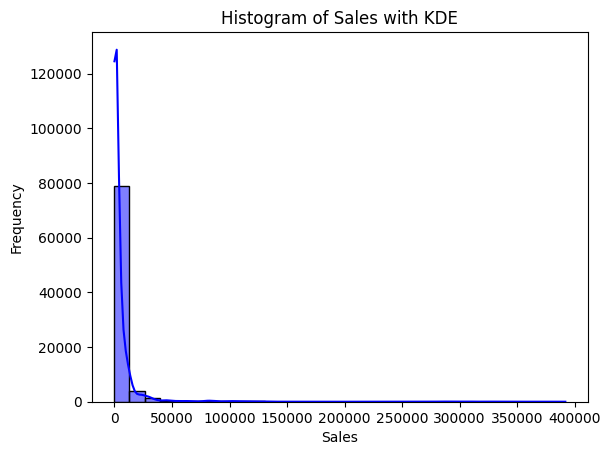

In [179]:
sns.histplot(df['sales'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title("Histogram of Sales with KDE")

# Show the plot
plt.show()

In [180]:
df['customers'].isna().value_counts()

customers
False    59830
True     26040
Name: count, dtype: int64

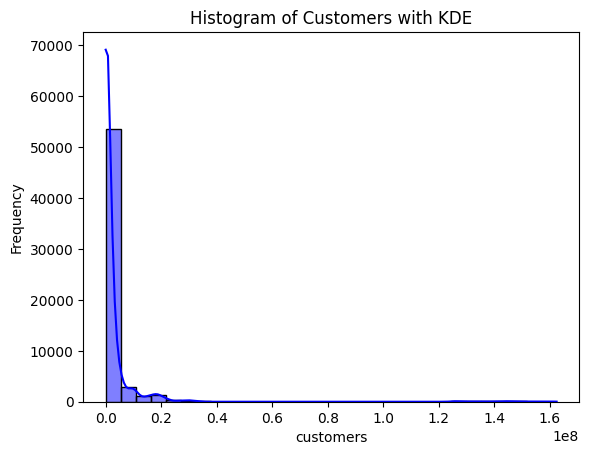

In [181]:
sns.histplot(df['customers'], bins=30, kde=True, color='blue')

# Add labels and title
plt.xlabel("customers")
plt.ylabel("Frequency")
plt.title("Histogram of Customers with KDE")

# Show the plot
plt.show()

### Covariate Analysis

In [182]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

In [183]:
df.groupby('year')[['price', 'sales', 'revenue']].mean()

,price,sales,revenue
year,,,
2001,7.621320,5474.932426,398.940476
2002,7.455519,5589.461308,402.275018
2003,6.569715,5635.055623,418.978795
2004,6.902169,5721.741102,435.676171
2005,7.562704,5904.787924,480.649711
2006,8.253118,5919.223935,526.622527
2007,8.497567,6071.872116,554.358966
2008,9.258411,6022.523580,586.424373
2009,9.103656,5801.282475,569.821393


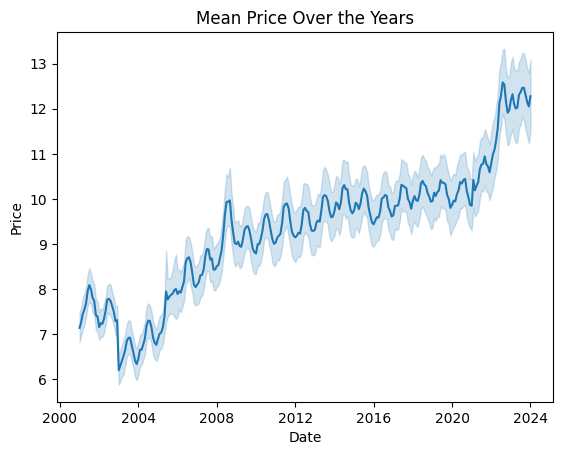

In [184]:
sns.lineplot(data=df, x='date', y='price')

# Customize plot
plt.title('Mean Price Over the Years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

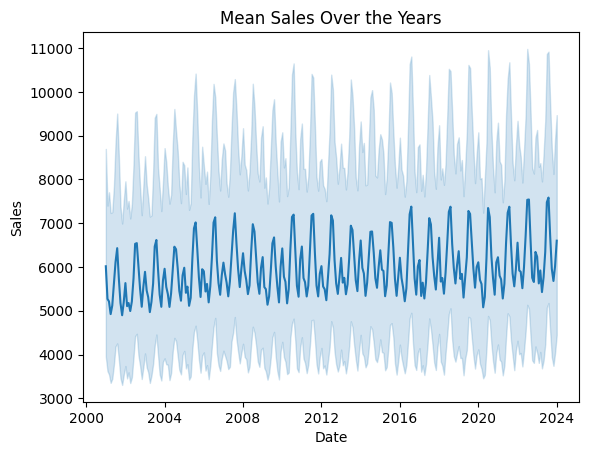

In [185]:
sns.lineplot(data=df, x='date', y='sales')

# Customize plot
plt.title('Mean Sales Over the Years')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

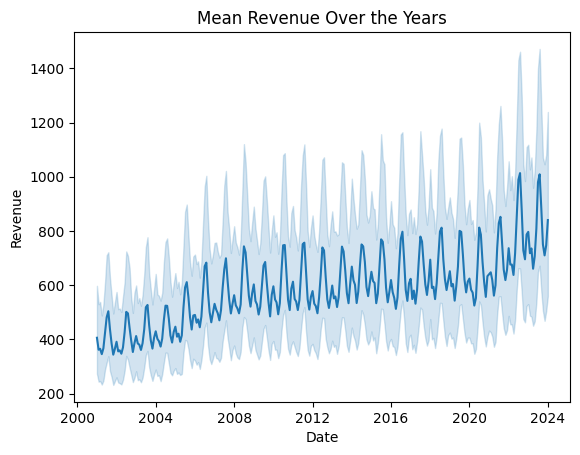

In [186]:
ax = sns.lineplot(data=df, x='date', y='revenue')

# Customize plot
plt.title('Mean Revenue Over the Years')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

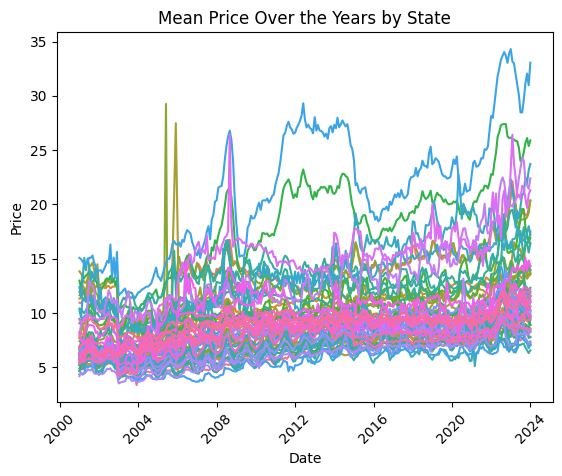

In [187]:
ax = sns.lineplot(data=df, x='date', y='price', hue='stateDescription', errorbar=None, legend=None)
#sns.move_legend(ax, "lower left")
# Customize plot
plt.title('Mean Price Over the Years by State')
plt.xlabel('Date')
plt.ylabel('Price')
#plt.legend(title='State', location='bottom')
plt.xticks(rotation=45) 
plt.show()

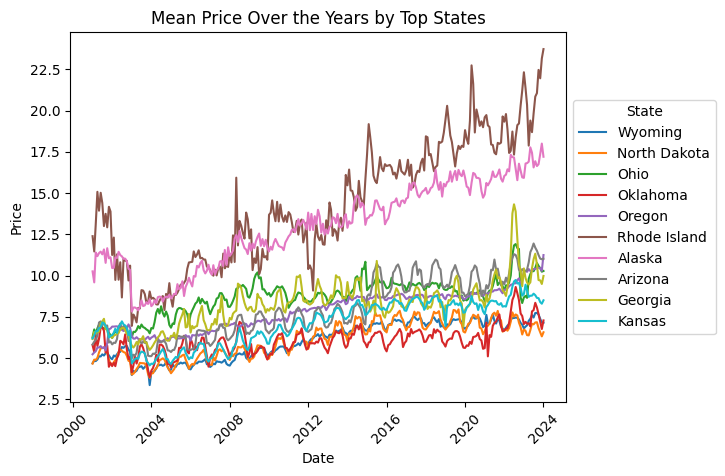

In [188]:
# Sort or select the top states based on frequency, for example:
top_states = df['stateDescription'].value_counts().head(10).index
df_top_states = df[df['stateDescription'].isin(top_states)]

ax = sns.lineplot(data=df_top_states, x='date', y='price', hue='stateDescription', errorbar=None)

# Move the legend to the lower-left position
sns.move_legend(ax, "lower left")

# Customize plot
plt.title('Mean Price Over the Years by Top States')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='State', loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend outside
plt.xticks(rotation=45)
plt.show()

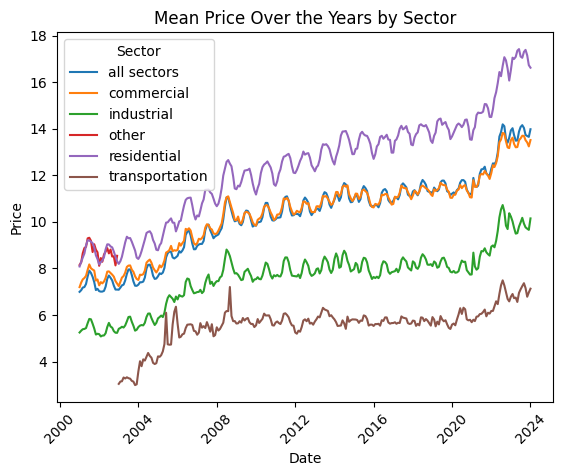

In [189]:
sns.lineplot(data=df, x='date', y='price', hue='sectorName', errorbar=None)

# Customize plot
plt.title('Mean Price Over the Years by Sector')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Sector')
plt.xticks(rotation=45) 
plt.show()

### Price distribution per sector

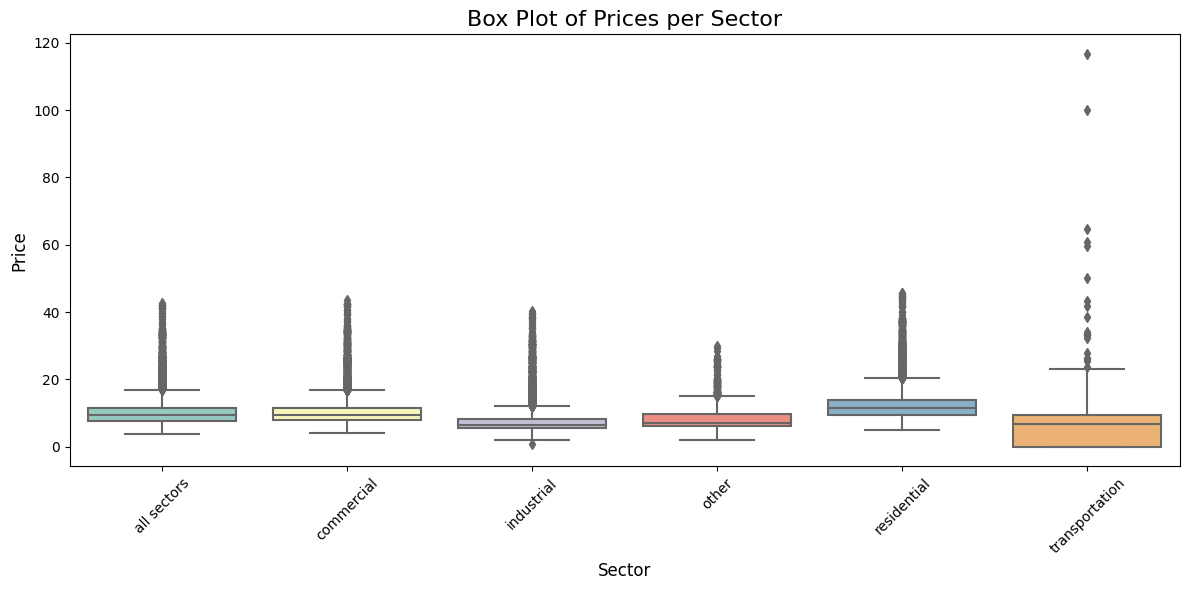

In [190]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='sectorName', y='price', palette='Set3')

# Customize the plot
plt.title('Box Plot of Prices per Sector', fontsize=16)
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Show the plot
plt.tight_layout()
plt.show()

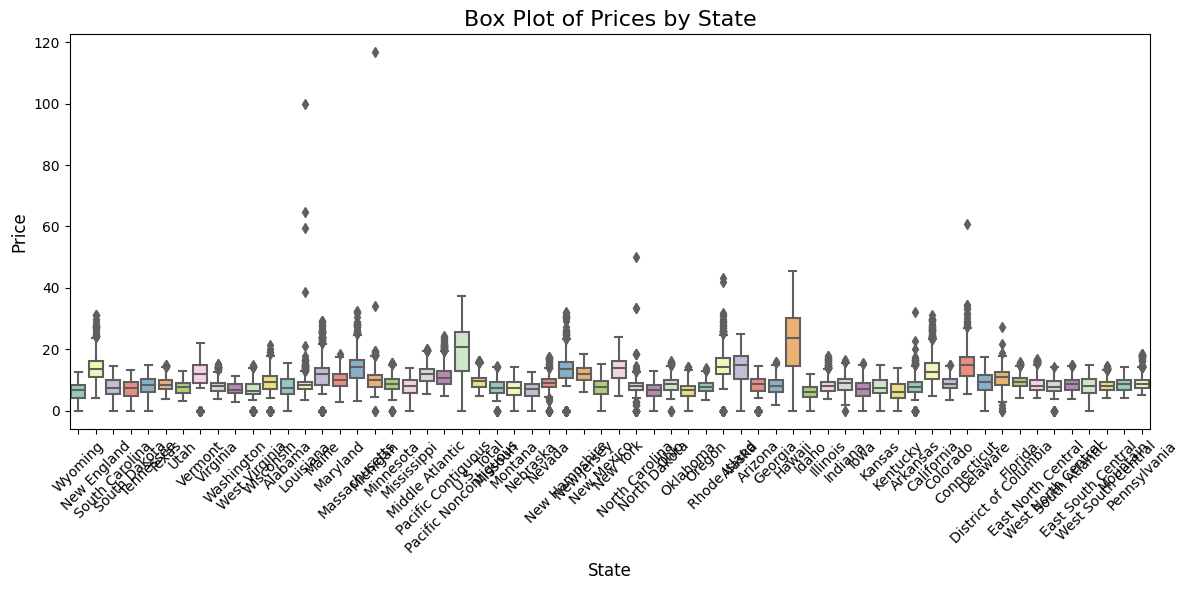

In [191]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='stateDescription', y='price', palette='Set3')

# Customize the plot
plt.title('Box Plot of Prices by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

# Show the plot
plt.tight_layout()
plt.show()

### Seasonal Decomposition

## For New York and the residential sector

In [192]:
df.set_index('date', inplace=True)

In [193]:
df_ny_residential = df[df['stateDescription']=='New York']
df_ny_residential = df_ny_residential[df_ny_residential['sectorName']=='residential']

In [194]:
df_ny_residential

,year,month,stateDescription,sectorName,customers,price,revenue,sales
date,,,,,,,,
2001-01-01,2001,1,New York,residential,NaN,13.89,579.86655,4175.33424
2001-02-01,2001,2,New York,residential,NaN,13.93,515.75364,3701.67426
2001-03-01,2001,3,New York,residential,NaN,13.58,500.04422,3682.95767
2001-04-01,2001,4,New York,residential,NaN,13.44,437.00018,3251.18097
2001-05-01,2001,5,New York,residential,NaN,14.01,432.91117,3090.92043
...,...,...,...,...,...,...,...,...
2023-09-01,2023,9,New York,residential,7393254.0,23.33,1080.07776,4629.23183
2023-10-01,2023,10,New York,residential,7390536.0,22.06,806.60309,3656.21194
2023-11-01,2023,11,New York,residential,7398579.0,22.95,829.26306,3614.03277


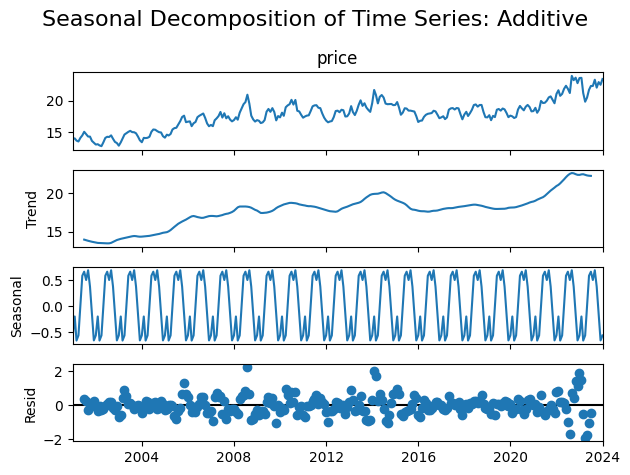

In [195]:
# Perform seasonal decomposition: additive
result = seasonal_decompose(df_ny_residential['price'], model='additive', period=12)  # 'period' is the seasonal cycle length

# Plot the components
result.plot()
plt.suptitle('Seasonal Decomposition of Time Series: Additive', fontsize=16)
plt.tight_layout()
plt.show()

# Access components programmatically
trend = result.trend
seasonal = result.seasonal
residual = result.resid

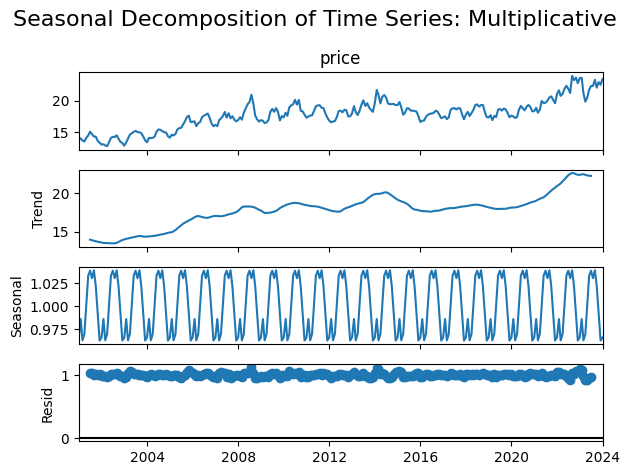

In [196]:
# Perform seasonal decomposition: additive
result = seasonal_decompose(df_ny_residential['price'], model='multiplicative', period=12)  # 'period' is the seasonal cycle length

# Plot the components
result.plot()
plt.suptitle('Seasonal Decomposition of Time Series: Multiplicative', fontsize=16)
plt.tight_layout()
plt.show()

# Access components programmatically
trend = result.trend
seasonal = result.seasonal
residual = result.resid

### The additive decomposition is better since residuals are more normally distributed

In [197]:
## add trend amd seasonal decomposition as features to dataframe
df_ny_residential['seasonal']= result.seasonal
df_ny_residential['trend']= result.trend

### Create Lag Features

In [198]:
# Create lag features
df_ny_residential['lag1'] = df_ny_residential['price'].shift(1)
df_ny_residential['lag7'] = df_ny_residential['price'].shift(7)

## Moving Averages

### Calculate moving averages

In [199]:
## 7-day Simple moving average
sma_window = 7  # 7-day moving average
sma = df_ny_residential['price'].rolling(window=sma_window).mean()
## 30-day Exponential moving average
ema_window = 30  # 30-day moving average
ema = df_ny_residential['price'].ewm(span=ema_window, adjust=False).mean()

### Plot moving averages

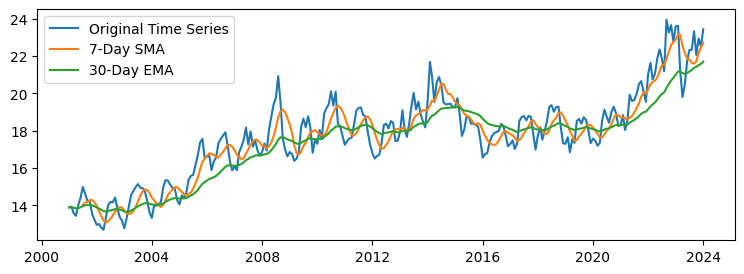

In [200]:
plt.figure(figsize=(9, 3))
plt.plot(df_ny_residential['price'], label='Original Time Series')
plt.plot(sma, label=f'{sma_window}-Day SMA')
plt.plot(ema, label=f'{ema_window}-Day EMA')
plt.legend()
plt.show()

### Add moving averages as features¶

In [201]:
df_ny_residential['rolling_avg_7'] = sma
df_ny_residential['exp_moving_avg_30'] = ema

### Outlier Detection

### Looking a z-score>3

In [202]:
df_ny_residential['z_score'] = zscore(df_ny_residential['price'])
outliers = df_ny_residential[abs(df_ny_residential['z_score']) > 3]

In [203]:
print(outliers)

Empty DataFrame
Columns: [year, month, stateDescription, sectorName, customers, price, revenue, sales, seasonal, trend, lag1, lag7, rolling_avg_7, exp_moving_avg_30, z_score]
Index: []


## There are no observations such that z-score>3,looking at z-score>2

In [204]:
outliers2 = df_ny_residential[abs(df_ny_residential['z_score']) > 2]
outliers2

,year,month,stateDescription,sectorName,customers,price,revenue,sales,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30,z_score
date,,,,,,,,,,,,,,,
2002-01-01,2002,1,New York,residential,NaN,12.95,528.17566,4077.94117,0.965665,13.599167,13.25,14.41,13.968571,13.886095,-2.032647
2002-02-01,2002,2,New York,residential,NaN,13.00,468.14273,3601.79329,0.985901,13.547083,12.95,14.99,13.684286,13.828927,-2.011414
2002-03-01,2002,3,New York,residential,NaN,12.81,451.94510,3527.31783,0.962637,13.536250,13.00,14.61,13.427143,13.763190,-2.092099
2002-04-01,2002,4,New York,residential,NaN,12.69,422.40782,3329.31039,0.969564,13.529583,12.81,14.23,13.207143,13.693952,-2.143058
2003-01-01,2003,1,New York,residential,NaN,12.77,566.16779,4432.82071,0.965665,13.996250,13.19,14.01,13.710000,13.671676,-2.109085
2022-09-01,2022,9,New York,residential,7336278.0,23.95,1166.84000,4871.89367,1.039024,22.517917,21.20,21.64,21.865714,20.301513,2.638572
2022-10-01,2022,10,New York,residential,7384092.0,23.26,826.05839,3550.87459,1.021523,22.484583,23.95,20.75,22.224286,20.492383,2.345559
2022-11-01,2022,11,New York,residential,7400113.0,23.66,815.80471,3448.43457,0.990901,22.374583,23.26,21.06,22.595714,20.696745,2.515421
2022-12-01,2022,12,New York,residential,7370759.0,22.78,964.72750,4234.46457,0.962397,22.289583,23.66,21.86,22.727143,20.831149,2.141724


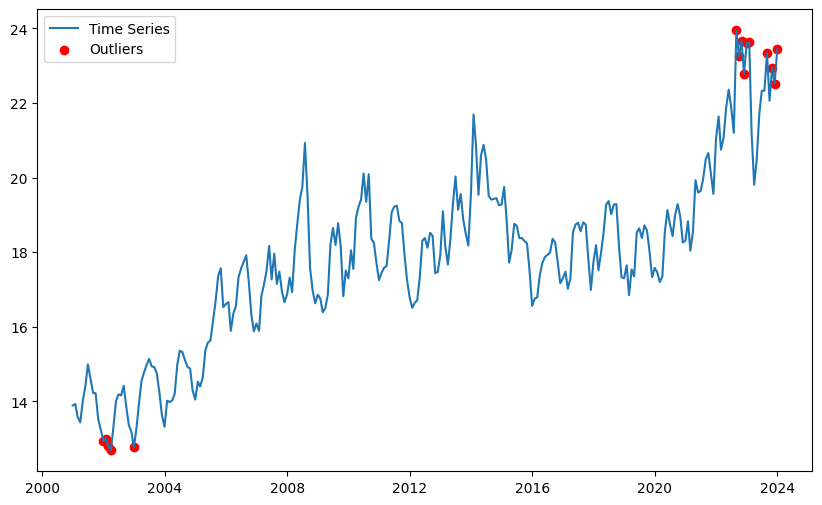

In [205]:
plt.figure(figsize=(10, 6))
plt.plot(df_ny_residential.index, df_ny_residential['price'], label='Time Series')
plt.scatter(outliers2.index, outliers2['price'], color='red', label='Outliers')
plt.legend()
plt.show()

#### The outliers occur in 2002-2003, 2022 and 2023-2024. 

#### Setting training and test dates:
* Train: 2001-01-01 to 2015-12-01

* Test: 2016-01-01 to 2019-12-01

Excluding prices from 2020 due to effects from COVID-19

In [206]:
train_start_date = pd.to_datetime('2000-01-01')
train_end_date = pd.to_datetime('2015-12-01')
test_start_date = pd.to_datetime('2016-01-01')
test_end_date = pd.to_datetime('2019-12-01')

## Bringing in External Data: Electricity prices depend on
* Cost of Generation: Fuel costs and costs from investment in renewable energy sources
* Seasonality and Weather Conditions
* Population Growth and Urbanization
* Regulatory and Policy Factors such as Government Subsidies for renewable energy or residential consumption
* Market and Economics Factors such as Inflation and unemployment

I will use **Weather Data** and **Macroeconomic Data**

### Bring in Weather Data

In [207]:
start = dt.datetime(2001, 1, 1)
end = dt.datetime(2024, 12, 31)
nyc = Point(40.7128, -74.0060)  # NYC coordinates
data = Monthly(nyc, start, end)
weather_data = data.fetch()

In [208]:
weather_data.head()

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
2001-01-01,0.2,-3.6,3.9,65.4,14.7,1016.4,NaN
2001-02-01,2.2,-2.3,6.5,45.6,18.0,1021.1,NaN
2001-03-01,4.6,0.7,8.1,169.9,19.6,NaN,NaN
2001-04-01,12.0,6.6,17.1,43.3,15.1,NaN,NaN
2001-05-01,17.9,12.7,22.9,73.3,15.7,1016.7,NaN


tsun: total sunlight duration

#### Fill in missing weather data

In [209]:
weather_data.fillna(method='ffill', inplace=True)

In [210]:
weather_data_train = weather_data[weather_data.index.year<=train_end_date.year]
weather_data_test = weather_data[(weather_data.index.year>=test_start_date.year) & (weather_data.index.year<=test_end_date.year)]

## Bring in Macroeconomic Data
Source: FRED

In [213]:
pop_data_path = '/kaggle/input/new-york-population/NYPOP.csv'
hh_income_data_path = '/kaggle/input/real-median-household-income-in-new-york/MEHOINUSNYA672N.csv'

population_data = pd.read_csv(pop_data_path)
hh_income_data = pd.read_csv(hh_income_data_path)

In [214]:
## join by date:
macroecon_data = population_data.merge(hh_income_data, how = 'inner', on = 'observation_date')

In [215]:
macroecon_data = macroecon_data.rename(columns = {'NYPOP': 'ny_population', 'MEHOINUSNYA672N': 'ny_median_hh_income'})
macroecon_data

,observation_date,ny_population,ny_median_hh_income
0,2000-01-01,19001.780,67950
1,2001-01-01,19082.838,68680
2,2002-01-01,19137.800,67600
3,2003-01-01,19175.939,67520
4,2004-01-01,19171.567,68730
5,2005-01-01,19132.610,70580
6,2006-01-01,19104.631,70110
7,2007-01-01,19132.335,69380
8,2008-01-01,19212.436,69000
9,2009-01-01,19307.066,68940


In [216]:
macroecon_data['observation_date'] = pd.to_datetime(macroecon_data['observation_date'] )
macroecon_data = macroecon_data.set_index('observation_date')

In [217]:
macroecon_data

,ny_population,ny_median_hh_income
observation_date,,
2000-01-01,19001.780,67950
2001-01-01,19082.838,68680
2002-01-01,19137.800,67600
2003-01-01,19175.939,67520
2004-01-01,19171.567,68730
2005-01-01,19132.610,70580
2006-01-01,19104.631,70110
2007-01-01,19132.335,69380
2008-01-01,19212.436,69000


In [218]:
macroecon_data_train = macroecon_data[macroecon_data.index.year<test_start_date.year]
macroecon_data_test = macroecon_data[(macroecon_data.index.year>=test_start_date.year) & (macroecon_data.index.year<=test_end_date.year)]

## Data Preprocessing
* Train-test split
* Differencing/ Detrending
* Transformations: Seasonalizing
* Impute missing values

### Identify missing data

In [221]:
df_ny_residential['price'].isna().sum()

0

### Feature engineering

In [232]:
df_xgb = df_ny_residential.copy()
df_xgb["day_of_year"] = df_xgb.index.dayofyear
df_xgb["month"] = df_xgb.index.month
df_xgb["quarter"] = df_xgb.index.quarter
df_xgb["year"] = df_xgb.index.year

df_xgb.head()

,year,month,stateDescription,sectorName,customers,price,revenue,sales,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30,z_score,day_of_year,quarter
date,,,,,,,,,,,,,,,,,
2001-01-01,2001,1,New York,residential,NaN,13.89,579.86655,4175.33424,0.965665,NaN,NaN,NaN,NaN,13.890000,-1.633470,1,1
2001-02-01,2001,2,New York,residential,NaN,13.93,515.75364,3701.67426,0.985901,NaN,13.89,NaN,NaN,13.892581,-1.616484,32,1
2001-03-01,2001,3,New York,residential,NaN,13.58,500.04422,3682.95767,0.962637,NaN,13.93,NaN,NaN,13.872414,-1.765114,60,1
2001-04-01,2001,4,New York,residential,NaN,13.44,437.00018,3251.18097,0.969564,NaN,13.58,NaN,NaN,13.844516,-1.824565,91,2
2001-05-01,2001,5,New York,residential,NaN,14.01,432.91117,3090.92043,1.000255,NaN,13.44,NaN,NaN,13.855193,-1.582511,121,2


In [233]:
X = df_xgb[["day_of_year", "month", "quarter", "year", "seasonal", "trend", "lag1", "lag7", "rolling_avg_7", "exp_moving_avg_30"]]
y = df_xgb["price"]

### Train-test split

In [234]:
train_dates = list(df_ny_residential.index[df_ny_residential['year'] <= train_end_date.year])
test_dates = list(df_ny_residential.index[(df_ny_residential['year'] >= test_start_date.year) &
                     (df_ny_residential['year'] <= test_end_date.year)])

In [266]:
X_train, y_train = X[X['year']<= train_end_date.year], y[X['year']<= train_end_date.year]
X_test, y_test = X[X['year']>= test_start_date.year], y[X['year']>= test_start_date.year]
X_test, y_test = X_test[X_test['year'] <= test_end_date.year], y_test[X_test['year']<= test_end_date.year]

#### Merging electricity data with weather data

In [236]:
merged_columns = ['year', 'month', 'day_of_year', 
                                  'quarter', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd',
                 "seasonal","trend", "lag1", "lag7", "rolling_avg_7", "exp_moving_avg_30"]
merged_data_train = X_train.merge(weather_data_train, how = 'inner', left_index=True, right_index=True)
merged_data_test = X_test.merge(weather_data_test, how = 'inner', left_index=True, right_index=True)

X_train_xgb_weather, X_test_xgb_weather = merged_data_train[merged_columns], merged_data_test[merged_columns]

In [237]:
X_train_xgb_weather

,year,month,day_of_year,quarter,tavg,tmin,tmax,prcp,wspd,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30
date,,,,,,,,,,,,,,,
2001-01-01,2001,1,1,1,0.2,-3.6,3.9,65.4,14.7,0.965665,NaN,NaN,NaN,NaN,13.890000
2001-02-01,2001,2,32,1,2.2,-2.3,6.5,45.6,18.0,0.985901,NaN,13.89,NaN,NaN,13.892581
2001-03-01,2001,3,60,1,4.6,0.7,8.1,169.9,19.6,0.962637,NaN,13.93,NaN,NaN,13.872414
2001-04-01,2001,4,91,2,12.0,6.6,17.1,43.3,15.1,0.969564,NaN,13.58,NaN,NaN,13.844516
2001-05-01,2001,5,121,2,17.9,12.7,22.9,73.3,15.7,1.000255,NaN,13.44,NaN,NaN,13.855193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,2015,8,213,3,25.9,20.6,31.2,35.5,13.2,1.030388,18.147917,18.71,19.28,18.614286,19.000815
2015-09-01,2015,9,244,3,23.1,17.8,28.2,59.3,12.5,1.039024,17.934583,18.38,19.75,18.418571,18.960763
2015-10-01,2015,10,274,4,14.0,8.9,19.1,85.1,15.6,1.021523,17.831667,18.38,18.92,18.330000,18.918133


### Additionally merging macroeconomic data

We need to merge on year because macroeconomic data is at an annual data

In [241]:
# extract year in macroecon datasets to join on
macroecon_data_train.loc[:,'year'] = macroecon_data_train.index.year
macroecon_data_test.loc[:,'year'] = macroecon_data_test.index.year

In [242]:
merged_data_train = X_train_xgb_weather.merge(macroecon_data_train, how = 'left', on = 'year')
merged_data_test = X_test_xgb_weather.merge(macroecon_data_test, how = 'left', on = 'year')

In [243]:
merged_data_train

,year,month,day_of_year,quarter,tavg,tmin,tmax,prcp,wspd,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30,ny_population,ny_median_hh_income
0,2001,1,1,1,0.2,-3.6,3.9,65.4,14.7,0.965665,NaN,NaN,NaN,NaN,13.890000,19082.838,68680
1,2001,2,32,1,2.2,-2.3,6.5,45.6,18.0,0.985901,NaN,13.89,NaN,NaN,13.892581,19082.838,68680
2,2001,3,60,1,4.6,0.7,8.1,169.9,19.6,0.962637,NaN,13.93,NaN,NaN,13.872414,19082.838,68680
3,2001,4,91,2,12.0,6.6,17.1,43.3,15.1,0.969564,NaN,13.58,NaN,NaN,13.844516,19082.838,68680
4,2001,5,121,2,17.9,12.7,22.9,73.3,15.7,1.000255,NaN,13.44,NaN,NaN,13.855193,19082.838,68680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2015,8,213,3,25.9,20.6,31.2,35.5,13.2,1.030388,18.147917,18.71,19.28,18.614286,19.000815,19657.321,72870
176,2015,9,244,3,23.1,17.8,28.2,59.3,12.5,1.039024,17.934583,18.38,19.75,18.418571,18.960763,19657.321,72870
177,2015,10,274,4,14.0,8.9,19.1,85.1,15.6,1.021523,17.831667,18.38,18.92,18.330000,18.918133,19657.321,72870
178,2015,11,305,4,11.4,6.5,15.8,33.2,13.2,0.990901,17.802917,18.30,17.72,18.402857,18.873737,19657.321,72870


## Covariate Analysis: Do Electricity Prices Vary with Weather or Macroeconomic Indicators?

In [244]:
merged_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 180 non-null    int32  
 1   month                180 non-null    int32  
 2   day_of_year          180 non-null    int32  
 3   quarter              180 non-null    int32  
 4   tavg                 180 non-null    float64
 5   tmin                 180 non-null    float64
 6   tmax                 180 non-null    float64
 7   prcp                 180 non-null    float64
 8   wspd                 180 non-null    float64
 9   seasonal             180 non-null    float64
 10  trend                174 non-null    float64
 11  lag1                 179 non-null    float64
 12  lag7                 173 non-null    float64
 13  rolling_avg_7        174 non-null    float64
 14  exp_moving_avg_30    180 non-null    float64
 15  ny_population        180 non-null    flo

####  Correlation of features

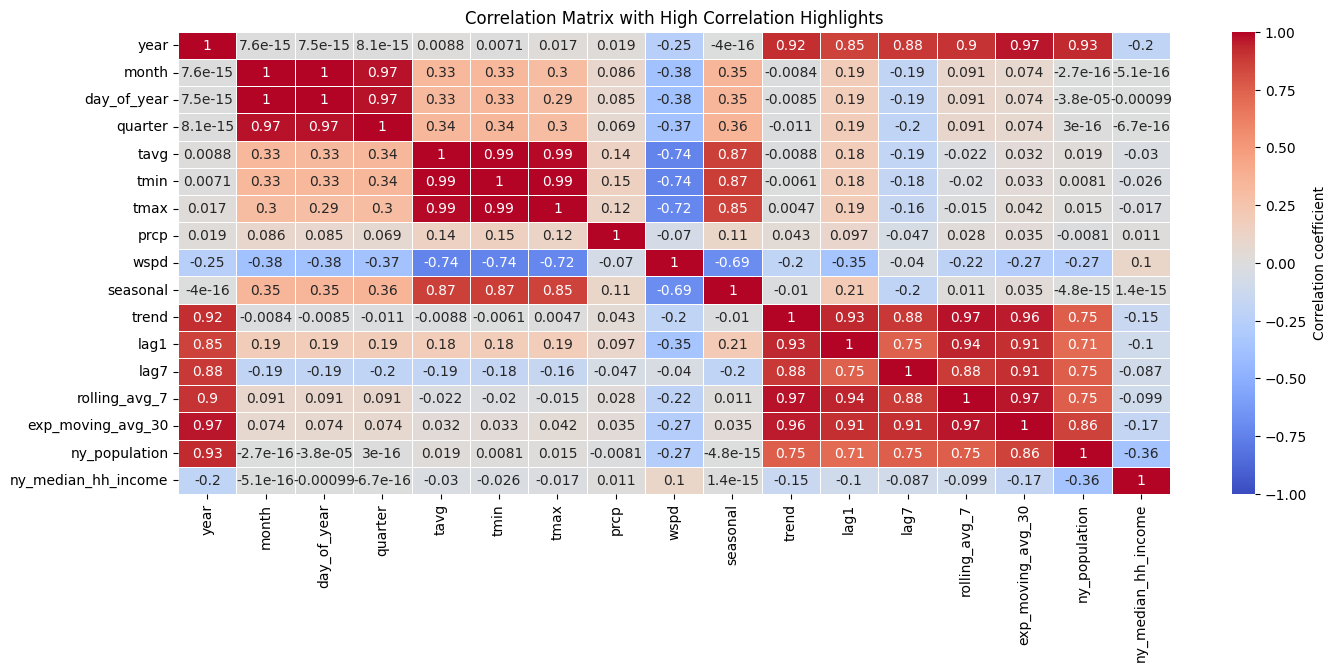

In [245]:
# Compute correlation matrix for features
corr_matrix = merged_data_train.corr()

# Create a heatmap with color highlighting for high correlation values
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'label': 'Correlation coefficient'})

# Show plot
plt.title('Correlation Matrix with High Correlation Highlights')
plt.show()

In [247]:
merged_data_train.isna().sum()

year                   0
month                  0
day_of_year            0
quarter                0
tavg                   0
tmin                   0
tmax                   0
prcp                   0
wspd                   0
seasonal               0
trend                  6
lag1                   1
lag7                   7
rolling_avg_7          6
exp_moving_avg_30      0
ny_population          0
ny_median_hh_income    0
dtype: int64

In [248]:
## Backfill columns with missing values - they are either lag features or moving averages
merged_data_train = merged_data_train.bfill()

### Correlation of features with target variable

In [249]:
merged_data_train

,year,month,day_of_year,quarter,tavg,tmin,tmax,prcp,wspd,seasonal,trend,lag1,lag7,rolling_avg_7,exp_moving_avg_30,ny_population,ny_median_hh_income
0,2001,1,1,1,0.2,-3.6,3.9,65.4,14.7,0.965665,13.968333,13.89,13.89,14.035714,13.890000,19082.838,68680
1,2001,2,32,1,2.2,-2.3,6.5,45.6,18.0,0.985901,13.968333,13.89,13.89,14.035714,13.892581,19082.838,68680
2,2001,3,60,1,4.6,0.7,8.1,169.9,19.6,0.962637,13.968333,13.93,13.89,14.035714,13.872414,19082.838,68680
3,2001,4,91,2,12.0,6.6,17.1,43.3,15.1,0.969564,13.968333,13.58,13.89,14.035714,13.844516,19082.838,68680
4,2001,5,121,2,17.9,12.7,22.9,73.3,15.7,1.000255,13.968333,13.44,13.89,14.035714,13.855193,19082.838,68680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2015,8,213,3,25.9,20.6,31.2,35.5,13.2,1.030388,18.147917,18.71,19.28,18.614286,19.000815,19657.321,72870
176,2015,9,244,3,23.1,17.8,28.2,59.3,12.5,1.039024,17.934583,18.38,19.75,18.418571,18.960763,19657.321,72870
177,2015,10,274,4,14.0,8.9,19.1,85.1,15.6,1.021523,17.831667,18.38,18.92,18.330000,18.918133,19657.321,72870
178,2015,11,305,4,11.4,6.5,15.8,33.2,13.2,0.990901,17.802917,18.30,17.72,18.402857,18.873737,19657.321,72870


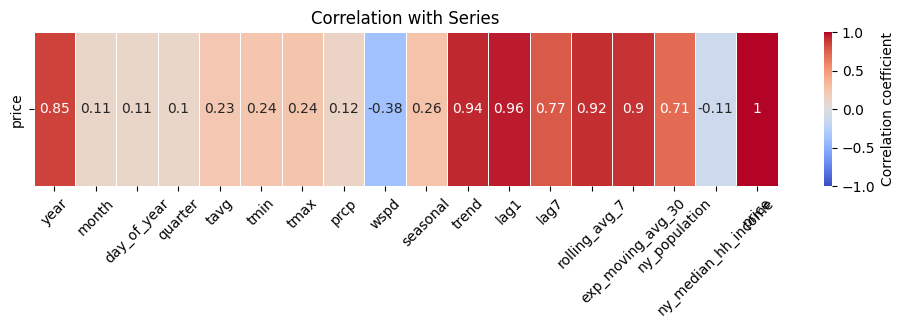

In [256]:
#correlation = merged_data_train[['year']].corrwith(y_train.reset_index().drop('date', axis=1))
# Reshape the correlation result for heatmap (1 row, n columns)
corr_matrix =  merged_data_train.merge(y_train.reset_index().drop(['date'], axis=1), left_index=True, right_index=True).corr()['price'].to_frame().T  # Transpose to have one row

# Plot the heatmap
plt.figure(figsize=(12, 2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'label': 'Correlation coefficient'})
plt.xticks(rotation=45)
# Show plot
plt.title('Correlation with Series')
plt.show()

## Data Preprocessing

### Normalizing data

Normalizing after train-test split to avoid data leakage due to normalization

In [267]:
scaler = MinMaxScaler()
X_train_ext_var = pd.DataFrame(scaler.fit_transform(merged_data_train), 
                                        columns = merged_data_train.columns,
                                       index = merged_data_train.index)

In [268]:
X_test_ext_var = pd.DataFrame(scaler.fit_transform(merged_data_test), 
                                        columns = merged_data_test.columns,
                                       index = merged_data_test.index)

### Backfill missing values

In [275]:
X_train = X_train.bfill()
X_train_ext_var = X_train_ext_var.bfill()

## Feature Selection

#### Use Feature Importance method of XGBoost

In [269]:
model_importance = XGBRegressor()
model_importance.fit(X_train_ext_var , y_train)
importances = model_importance.feature_importances_

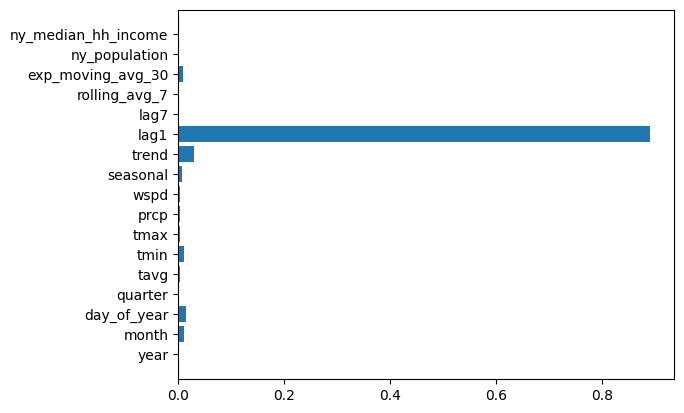

In [271]:
#Visualize importance
plt.barh(X_train_ext_var .columns, importances)
plt.show()

### Use SelectKBest

#### On X_train

In [287]:
k_best = SelectKBest(score_func=f_regression, k=6)
X_new = k_best.fit_transform(X_train, y_train)  # X: Features, y: Target
scores = k_best.scores_
selected_indices = k_best.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
selected_features

Index(['year', 'trend', 'lag1', 'lag7', 'rolling_avg_7', 'exp_moving_avg_30'], dtype='object')

In [288]:
X_train = X_train.loc[:, selected_features]
y_train_ext_var = y_train.reset_index().drop(['date'], axis=1)

In [289]:
X_test = X_test.loc[:, selected_features]

#### On larger dataset with external variables (X_train_ext_var)

In [482]:
k_best = SelectKBest(score_func=f_regression, k=9)
X_new = k_best.fit_transform(merged_data_train, y_train)  # X: Features, y: Target
scores = k_best.scores_
selected_indices = k_best.get_support(indices=True)
selected_features = merged_data_train.columns[selected_indices]
selected_features

Index(['year', 'wspd', 'seasonal', 'trend', 'lag1', 'lag7', 'rolling_avg_7',
       'exp_moving_avg_30', 'ny_population'],
      dtype='object')

In [483]:
X_train_ext_var = merged_data_train.loc[:, selected_features]
y_train_ext_var = y_train.reset_index().drop(['date'], axis=1)

In [484]:
X_test_ext_var = merged_data_test.loc[:, selected_features]

# Train Models

### Model 1: XGBoost Without External Data

In [280]:
model = XGBRegressor()
cv_split = TimeSeriesSplit(n_splits=3, test_size=48)

parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000]
}
grid_search_xgb1 = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search_xgb1.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=48),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impor...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

#### Predicting on Train Set

In [281]:
xgb_prediction_train = grid_search_xgb1.predict(X_train)

### Prediction on Test Set: Since we are using lag and rolling features, we must be careful about avoiding data leakage into the test set. The key is to ensure that all features in the test set are computed using only past information available at the time of prediction.

### Preparing Test Set Features Dynamically:

In [334]:
def update_decomposition(historical_data):
    # Combine historical data and the current test point
# Decompose using only available data
    #print(historical_data['price'].iloc[:-1])
    decomposition = seasonal_decompose(historical_data['price'].iloc[:-1], model='additive', period=12, extrapolate_trend='freq')
    
    # Extract components for the test point
    trend = decomposition.trend.iloc[-1]  # Last available trend value
    seasonal = decomposition.seasonal.iloc[-1]  # Last seasonal value
    return trend, seasonal

In [348]:
def predict_on_test_set(model, X_test, X_train, y_train):
    historical_data = X_train.merge(y_train, how = 'inner', left_index=True, right_index=True)
    
    for i in range(len(X_test)):
        # Access historical data
        historical_data = pd.concat([historical_data, X_test.iloc[i:i+1]], axis=0, ignore_index=True)

        test_point = X_test.iloc[i:i+1, :]
        #print(historical_data)
        # Compute lag and rolling features for the current test point
        historical_data.loc[i,'lag1'] = historical_data['price'].iloc[-1]
        historical_data.loc[i,'lag7'] = historical_data['price'].iloc[-7]
        historical_data.loc[i,'rolling_avg_7'] = historical_data['price'].iloc[-7:].mean()
        historical_data.loc[i,'exp_moving_avg_30'] = historical_data['price'].rolling(window=30, min_periods=1).apply(
        lambda x: x.ewm(span=ema_window, adjust=False).mean().iloc[-1], raw=False).iloc[-1]
        
        #Compute seasonal and trend features for the current test point
        trend, seasonal = update_decomposition(historical_data)
        historical_data.loc[:,'trend'] = trend
        #test_point.loc[:,'seasonal'] = seasonal
        # Predict using the trained model
        # Use the trained model to predict for the single row
        prediction = model.predict(test_point)
        #print(prediction)
        # if np.isnan(prediction):
        #     print("NaNs found in predictions!")
            # Debug inputs
            # print("Input data:", X_test)
                
        # Store the prediction in the test dataframe as the price for that row
        historical_data.iloc[-1, -1] = prediction

    return historical_data.iloc[len(X_train):, -1]

In [349]:
xgb_prediction_test = predict_on_test_set(grid_search_xgb1, X_test, X_train, y_train)

In [350]:
def evaluate_model(y_train, train_predictions, y_test, test_predictions):
    # Calculate metrics for train set
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mape = mean_absolute_percentage_error(y_train, train_predictions)
    
    # Calculate metrics for test set
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mape = mean_absolute_percentage_error(y_test, test_predictions)
    
    # Create a dataframe to display metrics
    metrics_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'MAPE'],
        'Train': [train_mae, train_mse, train_mape],
        'Test': [test_mae, test_mse, test_mape]
    })

    # Set 'Metric' as the index
    metrics_df.set_index('Metric', inplace=True)
    
    # Display the table
    print(metrics_df)
    return metrics_df

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

In [352]:
metrics_df_xgb1 = evaluate_model(y_train, xgb_prediction_train, y_test, xgb_prediction_test)

           Train      Test
Metric                    
MAE     0.103247  0.532280
MSE     0.019518  0.556672
MAPE    0.006192  0.030174


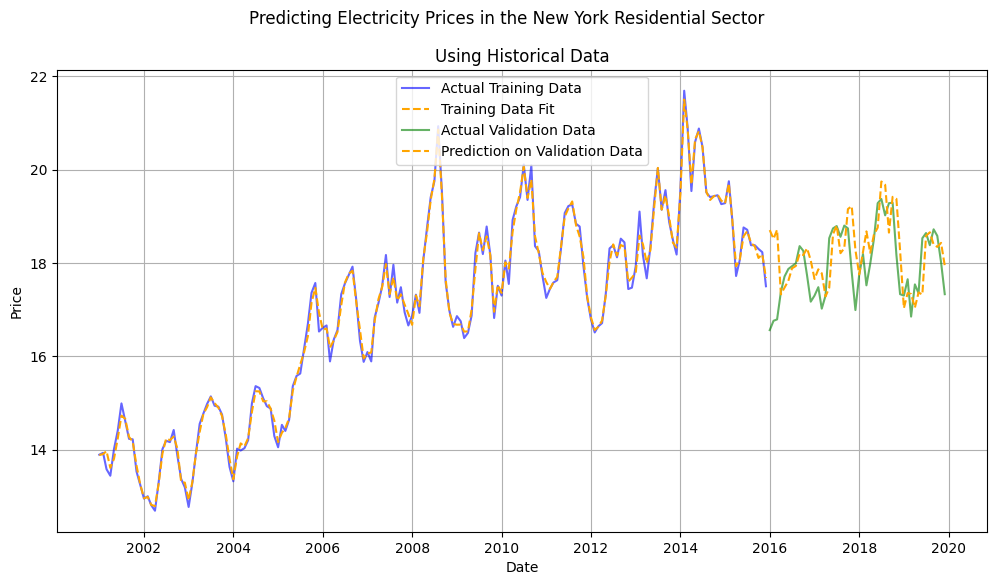

In [506]:
def plot_combined_predictions(train_dates, y_train, train_predictions, 
                               test_dates, y_test, test_predictions):
    plt.figure(figsize=(12, 6))

    # Plot training data and predictions
    plt.plot(train_dates, y_train, label='Actual Training Data', color='blue', alpha=0.6)
    plt.plot(train_dates, train_predictions, label='Training Data Fit', color='orange', linestyle='--')

    # Plot validation data and predictions
    plt.plot(test_dates, y_test, label='Actual Validation Data', color='green', alpha=0.6)
    plt.plot(test_dates, test_predictions, label='Prediction on Validation Data', color='orange', linestyle='--')

    # Customize the plot
    plt.suptitle('Predicting Electricity Prices in the New York Residential Sector')
    plt.title('Using Historical Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc = 'upper center')
    plt.grid()
    plt.savefig('plot1.png')
    plt.show()

# Example usage
plot_combined_predictions(
    train_dates, list(y_train), xgb_prediction_train, 
    test_dates, list(y_test), xgb_prediction_test
)

### Model 2: XGBoost With External Data Incorporated

In [452]:
# model_xgb_w = XGBRegressor()
# cv_split = TimeSeriesSplit(n_splits=3, test_size=48)

# parameters = {
#     "max_depth": [3, 5],
#     "learning_rate": [0.01, 0.05],
#     "n_estimators": [100, 300],
#     "min_child_weight" : [2,5],
#     "reg_alpha":[0.1,1.0],   # L1 regularization
#     "reg_lambda": [0.1,1.0]  #L2 regularization
# }
# grid_search_xgb_w = GridSearchCV(estimator=model, 
#                                  cv=cv_split, 
#                                  param_grid=parameters)
# grid_search_xgb_w.fit(X_train_ext_var, y_train_ext_var) # Stops after 10 rounds with no improvement)

In [485]:
model = XGBRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=100,
    reg_alpha=10.0,   # L1 regularization
    reg_lambda=5.0   # L2 regularization
)

# Train the model
model.fit(X_train_ext_var, y_train_ext_var)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [486]:
xgb_prediction_train_w = model.predict(X_train_ext_var) #grid_search_xgb_w

In [487]:
xgb_prediction_test_w = predict_on_test_set(model, X_test_ext_var, X_train_ext_var, y_train_ext_var)

In [488]:
metrics_df_xgb_w = evaluate_model( y_train, xgb_prediction_train_w,  y_test, xgb_prediction_test_w)

           Train      Test
Metric                    
MAE     0.348667  0.335198
MSE     0.246949  0.183144
MAPE    0.020752  0.018676


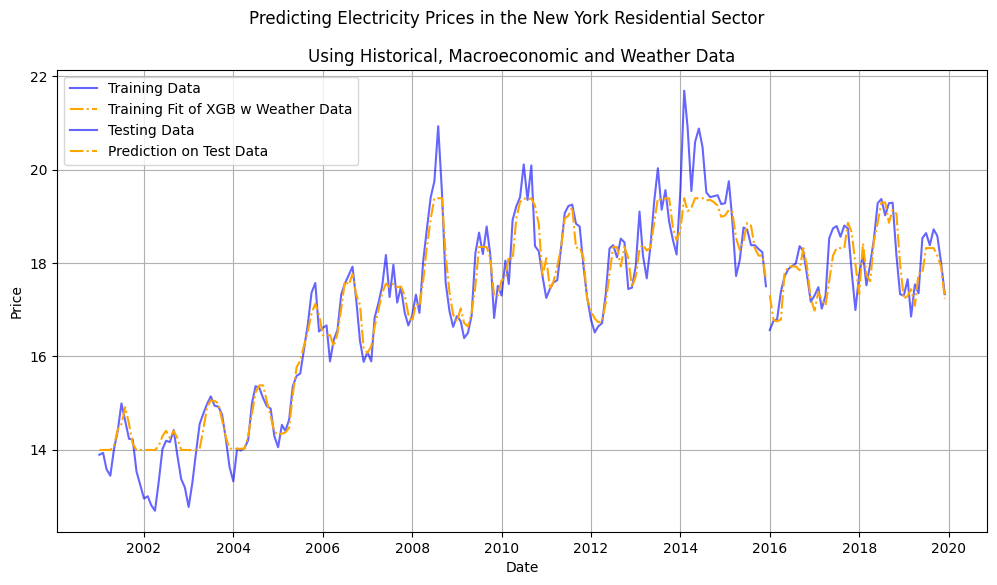

In [489]:
plt.figure(figsize=(12, 6))

# Plot training data and predictions
plt.plot(train_dates, y_train, label='Training Data', color='blue', alpha=0.6)
plt.plot(train_dates, xgb_prediction_train_w, label='Training Fit of XGB w Weather Data', color='orange', linestyle='-.')

# Plot validation data and predictions
plt.plot(test_dates, y_test, label='Testing Data', color='blue', alpha=0.6)
plt.plot(test_dates, xgb_prediction_test_w, label='Prediction on Test Data', color='orange', linestyle='-.')

# Customize the plot
plt.suptitle('Predicting Electricity Prices in the New York Residential Sector')
plt.title('Using Historical, Macroeconomic and Weather Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

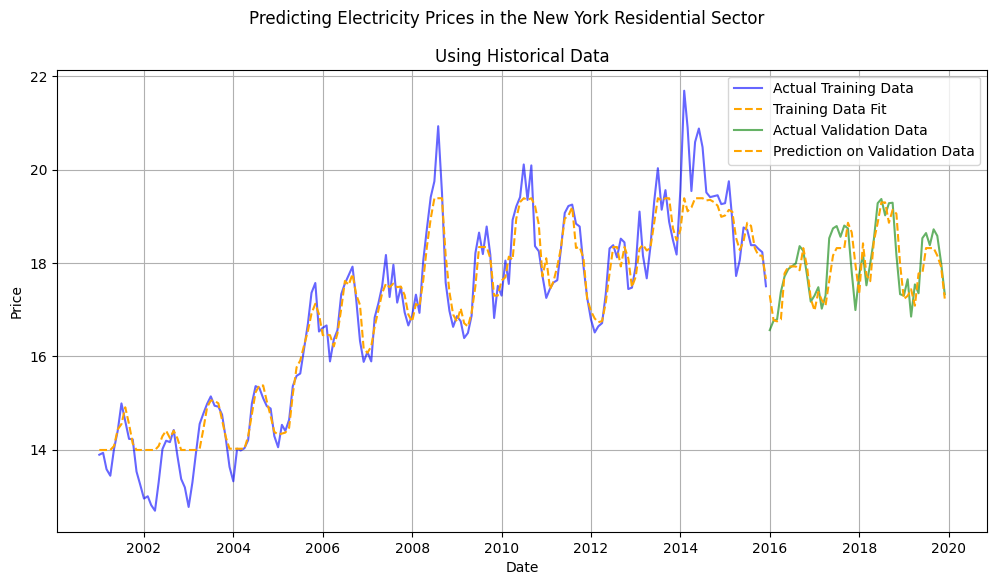

In [490]:
plot_combined_predictions(
    train_dates, list(y_train), xgb_prediction_train_w, 
    test_dates, list(y_test), xgb_prediction_test_w
)

#### Plot Combining Predictions of XGBoost without and with External Data

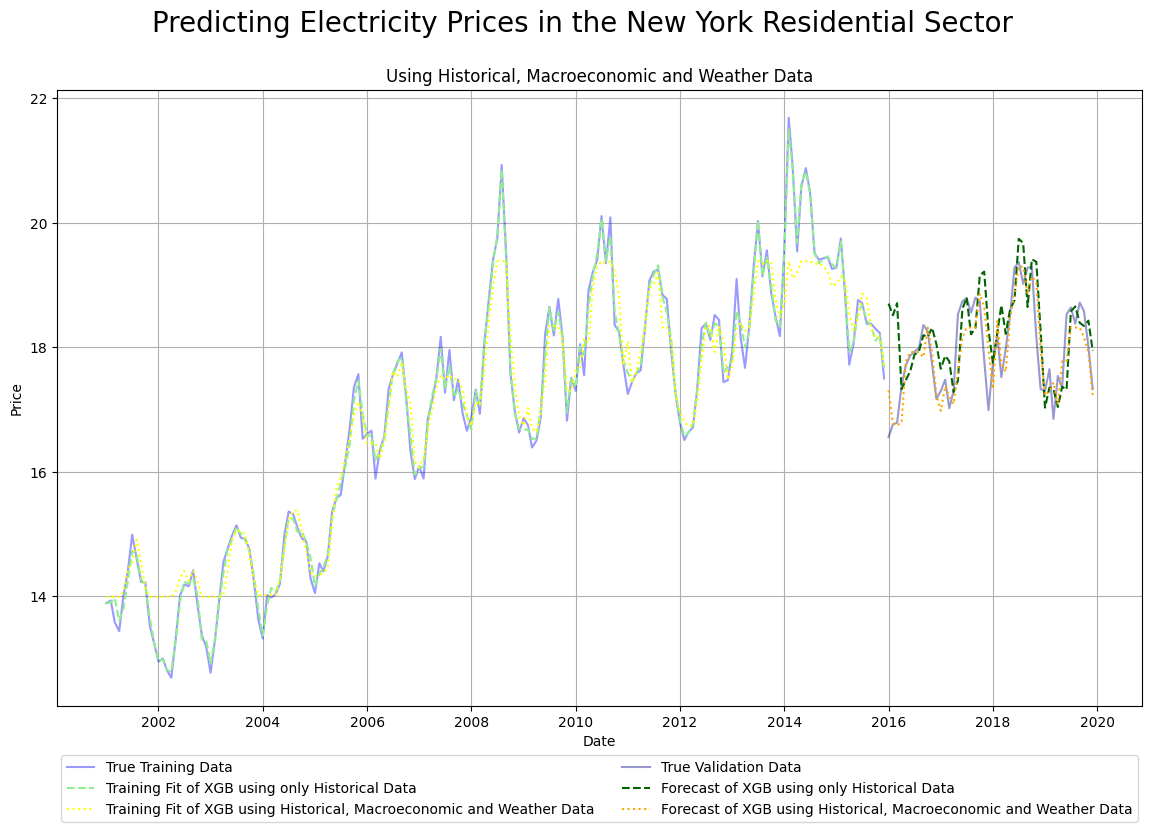

In [519]:
plt.figure(figsize=(14, 8))

# Plot training data and predictions
plt.plot(train_dates, y_train, label='True Training Data', color='blue', alpha=0.4)
plt.plot(train_dates, xgb_prediction_train, label='Training Fit of XGB using only Historical Data', color='lightgreen', linestyle='--')
plt.plot(train_dates, xgb_prediction_train_w, label='Training Fit of XGB using Historical, Macroeconomic and Weather Data', color='yellow', linestyle=':')

# Plot validation data and predictions
plt.plot(test_dates, y_test, label='True Validation Data', color='darkblue', alpha=0.4)
plt.plot(test_dates, xgb_prediction_test, label='Forecast of XGB using only Historical Data', color='darkgreen', linestyle='--')
plt.plot(test_dates, xgb_prediction_test_w, label='Forecast of XGB using Historical, Macroeconomic and Weather Data', color='orange', linestyle=':')

# Customize the plot
plt.suptitle('Predicting Electricity Prices in the New York Residential Sector', fontsize=20)
plt.title('Using Historical, Macroeconomic and Weather Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.grid()
plt.savefig('all_elec_predictions.png', bbox_inches='tight')
plt.show()


# Evaluation

### Compare the metrics of the 2 model 

In [523]:
def compare_models(metrics_table1, metrics_table2, model1_name='Model 1', model2_name='Model 2'):
    """
    Compare two metrics tables and output a combined comparison table.
    
    Parameters:
    - metrics_table1 (pd.DataFrame): First metrics table generated by `evaluate_model`.
    - metrics_table2 (pd.DataFrame): Second metrics table generated by `evaluate_model`.
    - model1_name (str): Name for the first model (default: 'Model 1').
    - model2_name (str): Name for the second model (default: 'Model 2').
    
    Returns:
    - pd.DataFrame: A comparison table showing metrics side by side.
    """
    # Rename columns for better identification
    metrics_table1 = metrics_table1.rename(columns={'Train': f'{model1_name} Train', 'Test': f'{model1_name} Test'})
    metrics_table2 = metrics_table2.rename(columns={'Train': f'{model2_name} Train', 'Test': f'{model2_name} Test'})

    # Merge the two tables on the 'Metric' column
    comparison_table = pd.merge(metrics_table1, metrics_table2, on='Metric', how='inner')
    comparison_table = comparison_table.rename(columns = {'Model 1 Test':'Model 1 Validation',
                                                         'Model 2 Test':'Model 2 Validation'})
    return comparison_table

In [524]:
# Compare the two models
comparison = compare_models(metrics_df_xgb1, metrics_df_xgb_w , model1_name='Model 1', model2_name='Model 2')


In [525]:
comparison

,Model 1 Train,Model 1 Validation,Model 2 Train,Model 2 Validation
Metric,,,,
MAE,0.103247,0.532280,0.348667,0.335198
MSE,0.019518,0.556672,0.246949,0.183144
MAPE,0.006192,0.030174,0.020752,0.018676


# Conclusion

### The XGBoost model trained on only historical electricity prices achieved 3% MAPE on validation data, while the one incorporating weather and macroeconomic variables achieved a 1.8% MAPE, a 40% improvement on the base model.

This demonstrates the significant impact of weather and macroeconomic data on electricity price forecasting, providing actionable insights for energy planners.

However,regularization is key to prevent overfitting when adding features. Using more than 8 features when incorporating external variables in Model 2 led to a lower validation error for the model than Model 1. Adding regularization, and lowering the number of features selected to 8 led to a higher training error but lower validation error.

As is visible in the table above, Model 2 had a higher training error than Model 1, but a lower validation error